In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [467]:
class RecSim():
    '''
    
    '''
    # df holds information on the grid
    df = None
    # time-varying information
    d = None
    
    nbins = 0
    coord_names = np.array(['x', 'y', 'z'])
    coord_steps = []
    coord_bins = []
    coord_values = None
    t = 0.
    dt = 0.
    
    def __init__(self, x, y, z, dt, **config):
        '''
        Initialize simulation.
        x,y and z must be passed as parameter values on the grid and are assumed to be linspaced.
        config is a configuration dict with settings for the simulation.
        '''
        self.set_coords(x,y,z)
        self.config = config
        self.d = []
        self.dt = dt
        return
    
    def set_coords(self, x, y, z):
        if self.df is not None:
            print('Warning: overwriting data...')
        # Produce parameter array
        self.x = x 
        self.y = y 
        self.z = z 
        self.coord_steps = np.array([np.unique(np.diff(coord))[0] for coord in [x,y,z]])
        self.coord_bins  = np.array([len(coord) for coord in [x,y,z]])
        coords = np.meshgrid(self.x, self.y, self.z)
        coords = [_coord.flatten() for _coord in coords]
        self.df = pd.DataFrame()
        for name, coord in zip(self.coord_names, coords):
            self.df[name] = coord
        self.nbins = len(self.df)
        return
    
    def set_density_sphere(self, radius, center, name):
        self.df[name] = np.zeros(self.nbins)
        r_from_center = np.sqrt(np.sum([(self.df[coord] - center[i])**2 for i, coord in enumerate(self.coord_names)], axis=0))
        self.df[name][r_from_center <= radius] = 1.
        return
    
    def plot_density(self, name, axes_numbers = [0, 2], **kwargs):
        x, y = self.coord_names[axes_numbers]
        grouped = self.df.groupby(by = (x, y)).sum()
        grouped[x] = grouped.index.get_level_values(x).values
        grouped[y] = grouped.index.get_level_values(y).values
        #return grouped
        plt.imshow(np.reshape(grouped[name].values, (self.coord_bins[axes_numbers])).T, **kwargs)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(name)
        return grouped[x].values, grouped[y].values, grouped[name].values
    
    def diffuse(self, name, diffconst):
        ret = {}
        # Values in the grid
        vals = self.df[name].values
        ret[name + '_sum'] = np.sum(vals)
        # Reshape array
        grid = np.reshape(vals, self.coord_bins)
        
        difflist = []
        empty_x = np.zeros(shape = np.shape(grid[[0], :, :]), dtype=float)
        difflist.append(np.concatenate([empty_x, grid[:-1, :, :]], axis=0).flatten())
        difflist.append(np.concatenate([grid[1:, :, :], empty_x], axis=0).flatten())
        
        empty_y = np.zeros(shape = np.shape(grid[:, [0], :]), dtype=float)
        difflist.append(np.concatenate([empty_y, grid[:, :-1, :]], axis=1).flatten())
        difflist.append(np.concatenate([grid[:, 1:, :], empty_y], axis=1).flatten())
        
        empty_z = np.zeros(shape = np.shape(grid[:, :, [0]]), dtype=float)
        difflist.append(np.concatenate([empty_z, grid[:, :, :-1]], axis=2).flatten())
        difflist.append(np.concatenate([grid[:, :, 1:], empty_z], axis=2).flatten())
        
        ret[name + '_out_x-'] = np.sum(grid[0,  :, :])
        ret[name + '_out_x+'] = np.sum(grid[-1, :, :])
        ret[name + '_out_y-'] = np.sum(grid[:,  0, :])
        ret[name + '_out_y+'] = np.sum(grid[:, -1, :])
        ret[name + '_out_z-'] = np.sum(grid[:, :,  0])
        ret[name + '_out_z+'] = np.sum(grid[:, :, -1])
        ret[name + '_out'] = np.sum(ret[name + '_out_' + coord + parity] for coord in self.coord_names 
                                    for parity in ['+', '-'])
        
        netflux = np.sum(difflist, axis=0)
        self.df[name] = self.df[name] + netflux * diffconst - self.df[name] * diffconst * 6        
        return ret
    
    def recombine(self, name0, name1, alpha):
        ret = {}
        # Compute overlap
        overlap = self.df[name0] * self.df[name1]
        recombined = overlap * alpha * self.dt
        # alpha defines the probability of recombination
        self.df[name0] = self.df[name0] - recombined
        self.df[name1] = self.df[name1] - recombined
        ret['ex_production'] = np.sum(recombined)
        return ret
    
    def decay(self, tau):
        ret = {}
        if len(self.d) == 0:
            ex_n = 0
        else:
            ex_n = self.d[-1]['ex_n']
        ret['ex_decay'] = ex_n * self.dt / tau
        return ret
    
    def evolve_one_step(self):
        tdict = {}
        # First diffuse electrons
        tdict.update(self.diffuse('e', self.config['e_diff_const']))
        tdict.update(self.recombine('e', 'ion', self.config['alpha']))
        tdict.update(self.decay(self.config['tau']))
        if len(self.d) == 0:
            ex_n = tdict['ex_production'] - tdict['ex_decay']
        else:
            ex_n = tdict['ex_production']  - tdict['ex_decay'] + self.d[-1]['ex_n']
        tdict['ex_n'] = ex_n
        tdict['t'] = self.t
        self.t = self.t + self.dt
        self.d.append(tdict)
        return
        
    def evolve(self, nsteps, tqdm=False):
        if tqdm:
            for i in tqdm(range(nsteps)):
                self.evolve_one_step()
        else:
            for i in range(nsteps):
                self.evolve_one_step()
            
    def data(self):
        return pd.DataFrame(self.d)
                

In [502]:
rs = RecSim(np.linspace(-20, 20, 41), np.linspace(-20, 20, 41), np.linspace(-20, 20, 41), dt=1, 
           e_diff_const = 0.1, alpha=0.1, tau=22)

In [503]:
rs.set_density_sphere(5, [0, 0, 0], 'e')

In [504]:
rs.set_density_sphere(5, [0, 0, 0], 'ion')

In [557]:
rs.evolve(500)

In [558]:
d = rs.data()

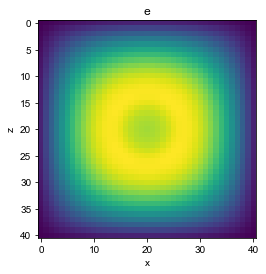

In [559]:
rs.plot_density('e')
plt.show()

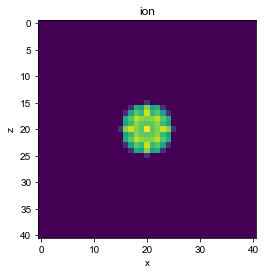

In [560]:
rs.plot_density('ion')
plt.show()

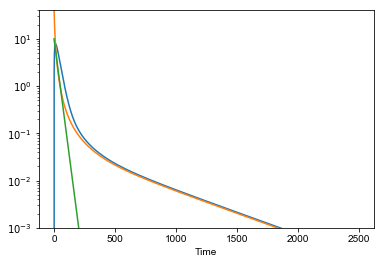

In [561]:
plt.plot(d['t'], d['ex_decay'], label = 'decay')
plt.plot(d['t'], d['ex_production'], label='production')
plt.plot(d['t'], 10 * np.exp(-d['t'] / 22), label='direct ex')
# plt.plot(d['t'], d['ex_n'])
plt.ylim(1e-3, 40)
plt.xlabel('Time')
plt.yscale('log')

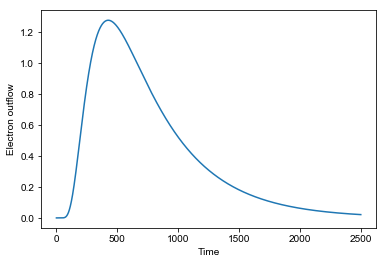

In [562]:
plt.plot(d['t'], d['e_out'], label = 'decay')
plt.xlabel('Time')
plt.ylabel('Electron outflow')

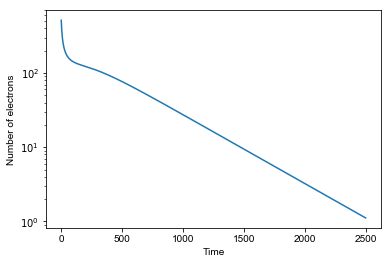

In [563]:
plt.plot(d['t'], d['e_sum'], label = 'Total n_electrons')
plt.xlabel('Time')
plt.ylabel('Number of electrons')
plt.yscale('log')